In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, probplot

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit, GroupKFold

from tqdm import tqdm
from typing import List, Optional, Tuple

from catboost import cv, CatBoostClassifier, Pool

%matplotlib inline
sns.set(font_scale=1.25)

Задание на повторение:
<br>Задание не обязательно к выполнению, но очень рекомендуется для понимания набора данных и получения гипотез для проведения валидации.
<br>Задание 1: Построить график распределения времени совершения транзакции для обучающей / тестовой выборки, сделать выводы о том, как разбиты данные и какие виды валидации могут подойти для данной задачи.
<br>Задание 2: построить scatter-plot зависимости суммы транзакции от времени совершения транзакции. Построить графики для обучающей выборки и для тестовой выборки, для обучающей выборки - построить как для целевой переменной = 0, так и для переменной = 1. Сделать выводы.
<br>Задание 3: построить распределение признака TransactionAmt в логарифмическом масштабе, сделать выводы о близости распредления к нормальному распределению. Построить распределение признака в логарифмическому масштабе для обучающей выборк и для тестовой выборки, сделать выводы.
<br>Задание 4: построить распределение признака целевой переменной в зависимости от значений категориальных признаков ProductCD, card4, card6. Сделать выводы.

Основное задание:
<br>Даны выборки для обучения и для тестирования. Задание заключается в том, чтобы попробовать разные способы валидации, проанализировать плюсы / минусы каждой и сделать выводы о том, какой способ валидации наиболее устойчивый в данной задаче. Метрика качества для оценки прогнозов - ROC-AUC, название целевой переменной - IsFraud. Рекомендуется использовать модели градиетного бустинга, реализация любая.

Задание 1: сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (TransactionID), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на тестовой выборке, оценить расхождение по сравнению с качеством на обучающей выборке и тестовой выборке.

Задание 2: сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1.

Задание 3: построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на тестовом выборке относительно полученного доверительного интервала. Сделать выводы.

Задание 4: выполнить Adversarial Validation на основе данных из обучения / теста, подобрать объема из обучающей выборки, которые сильно похожи на объекты из тестовой выборки, и использовать их в качестве валидационного набора. Сделать выводы о полученных результатах.

Задание 5: сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных;

Задание 6 * (опциональное): сделать Hold-Out валидацию по времени (TransactionDT), повторить процедуры из п.1 / п.2 (на ваш выбор). Построить доверительный интервал, сравнить качество на тестовой выборке с полученным доверительным интервалом. Сделать выводы.

Задание 7 ** (совсем опциональное): в данном наборе данных у нас есть ID-транзакции (TransactionID) и время транзакции (TransactionDT), но отсутствует ID-клиента, который совершал транзакции. Кажется, что в этой задаче валидация по клиенту работала бы хорошо. Предложить критерий, по которому можно выделить клиентов и сделать п.5, используя созданное определение клиента, используя валидацию по клиенту (GroupKFold).

## Задание на повторение

Данные для обучения и теста:

In [2]:
train_df = pd.read_csv('assignment_train.csv')
train_df.head(n=5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
test_df = pd.read_csv('assignment_test.csv')
test_df.head(n=5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3062000,0,1643492,41.0,W,9500,321.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3062001,1,1643513,161.0,W,6668,390.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3062002,0,1643519,49.0,W,14935,543.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3062003,0,1643519,100.0,R,8394,490.0,150.0,visa,226.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3062004,0,1643529,97.0,W,9500,321.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Размерности датафреймов:

In [4]:
print("train_df.shape = {} rows, {} cols".format(*train_df.shape))
print("test_df.shape = {} rows, {} cols".format(*test_df.shape))

train_df.shape = 50001 rows, 394 cols
test_df.shape = 75000 rows, 394 cols


Узнаем типы признаков:

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50001 entries, 0 to 50000
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 150.3+ MB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 225.4+ MB


Базовый анализ целевого признака (мошенничество ли?):

In [7]:
target_column = 'isFraud'

In [8]:
train_df[target_column].value_counts(normalize=True)

0    0.972861
1    0.027139
Name: isFraud, dtype: float64

Присутствует существенный дисбаланс классов - мошеннических операций всего 2.7%.

### Задание 1

Построить график распределения времени совершения транзакции для обучающей / тестовой выборки, сделать выводы о том, как разбиты данные и какие виды валидации могут подойти для данной задачи.

Подтвердим то, что признак `TransactionDT` в датафреймах упорядочен по убыванию, и выведем его минимальное и максимальное значения:

In [9]:
for df, df_type in zip([train_df, test_df], ['train', 'test']):
    
    np.testing.assert_array_equal(
        df['TransactionDT'],
        df['TransactionDT'].sort_values(ascending=True)
    )
    
    print(f"{df_type}: from {df['TransactionDT'].min()} to {df['TransactionDT'].max()}")

train: from 86400 to 1189349
test: from 1643492 to 3093408


Сколько транзакций было в каждый из моментов времени:

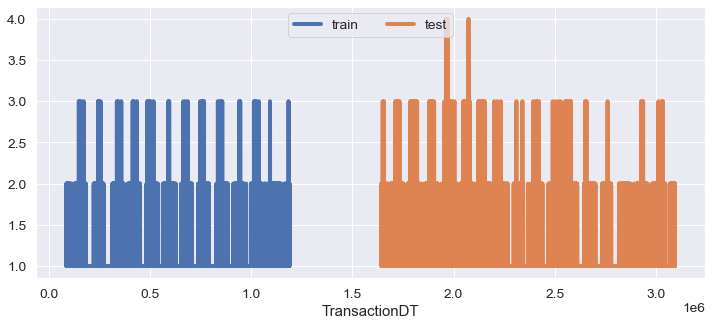

In [10]:
plt.figure(figsize=(12, 5))

for df, df_type in zip([train_df, test_df], ['train', 'test']):
    gb = df['TransactionDT'].value_counts().sort_index()
    plt.plot(gb.index, gb.values, linewidth=4, label=df_type)

plt.legend(loc='upper center', ncol=2)    
plt.xlabel('TransactionDT')
plt.show()

Тестовые данные взяты через отступ после данных для обучения.<br>Как правило, так делается, если в данных есть временная зависимость. Тем не менее, в контексте задачи выявляния мошенничества можно представить, что транзакции в них не зависят друг от друга. Поэтому рассматривается как **обычная кросс-валидация**, так и **кросс-валидация по времени**. 

### Задание 2

Построить scatter-plot зависимости суммы транзакции от времени совершения транзакции. Построить графики для обучающей выборки и для тестовой выборки, для обучающей выборки - построить как для целевой переменной = 0, так и для переменной = 1. Сделать выводы.

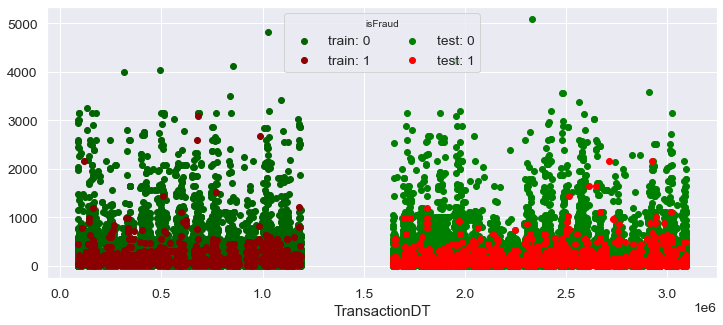

In [11]:
plt.figure(figsize=(12, 5))

for df, df_type in zip([train_df, test_df], ['train', 'test']):
    for target_value, c in zip([0, 1], ['green', 'red']):
        sat = 'dark' if df_type == 'train' else ''
        temp_df = df.loc[df[target_column] == target_value, ['TransactionDT', 'TransactionAmt']]
        label = f'{df_type}: {target_value}'
        plt.scatter(temp_df['TransactionDT'], temp_df['TransactionAmt'], c=sat+c, label=label)

plt.legend(loc='upper center', ncol=2, title=target_column)
plt.xlabel('TransactionDT')
plt.show()

Визуально мошеннические транзакции по сумме, в основном, не превышают 500 у.е. - как и большинство обычных транзакций.

### Задание 3

Построить распределение признака TransactionAmt в логарифмическом масштабе, сделать выводы о близости распредления к нормальному распределению. Построить распределение признака в логарифмическому масштабе для обучающей выборк и для тестовой выборки, сделать выводы.

In [12]:
train_tal = train_df['TransactionAmt'].apply(np.log)
test_tal = test_df['TransactionAmt'].apply(np.log)

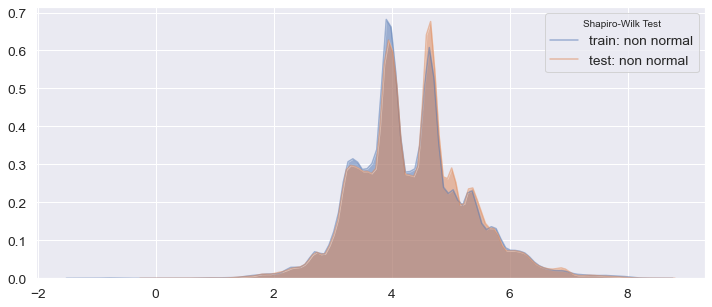

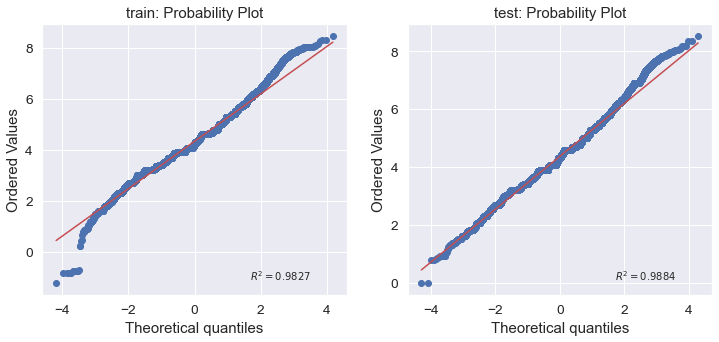

In [13]:
plt.figure(figsize=(12, 5))
for df_tal, df_type in zip([train_tal, test_tal], ['train', 'test']):    
    statistic, pvalue = shapiro(np.random.choice(df_tal, size=5000))
    shapiro_test = 'normal' if pvalue >= 0.05 else 'non normal'
    label = f'{df_type}: {shapiro_test}'
    sns.kdeplot(df_tal, shade=True, alpha=0.5, label=label)
plt.legend(loc='upper right', title='Shapiro-Wilk Test')
plt.show()

plt.figure(figsize=(12, 5))
for i, df_tal, df_type in zip([1, 2], [train_tal, test_tal], ['train', 'test']):    
    ax = plt.subplot(1, 2, i)
    res = probplot(df_tal, dist='norm', plot=ax, rvalue=True)
    plt.title(f'{df_type}: {ax.get_title()}')

В логарифмическом масштабе распределения признака `TransactionAmt` колоколообразны и мультимодальны, кроме того - сильно схожи в данных для обучения и теста.
<br>Q-Q графики и критерий Шапиро-Уилка не подтверждает их нормальность.

### Задание 4

Построить распределение признака целевой переменной в зависимости от значений категориальных признаков ProductCD, card4, card6. Сделать выводы.

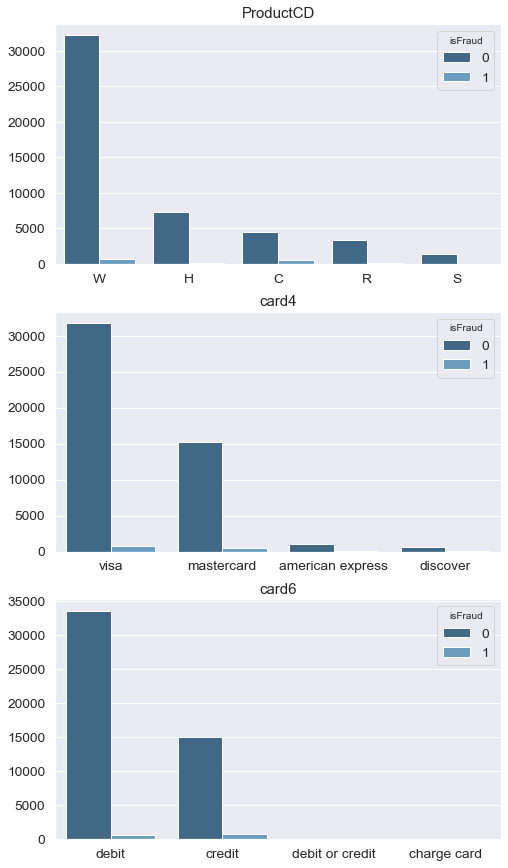

In [14]:
plt.figure(figsize=(8, 15))
for i, feature in enumerate(['ProductCD', 'card4', 'card6']):
    plt.subplot(3, 1, i+1)
    order = train_df[feature].value_counts().index
    sns.countplot(x=feature, hue=target_column, data=train_df, order=order, palette="Blues_d")
    plt.legend(loc='upper right', title=target_column)
    plt.title(feature)
    plt.xlabel('')
    plt.ylabel('')

Судя по диаграммам, больше мошеннических операций (относительно других значений признаков) - в случаях, если признак `ProductCD` принимает значение `C`, а признак `card6` - `credit`.

*Другой вариант:*

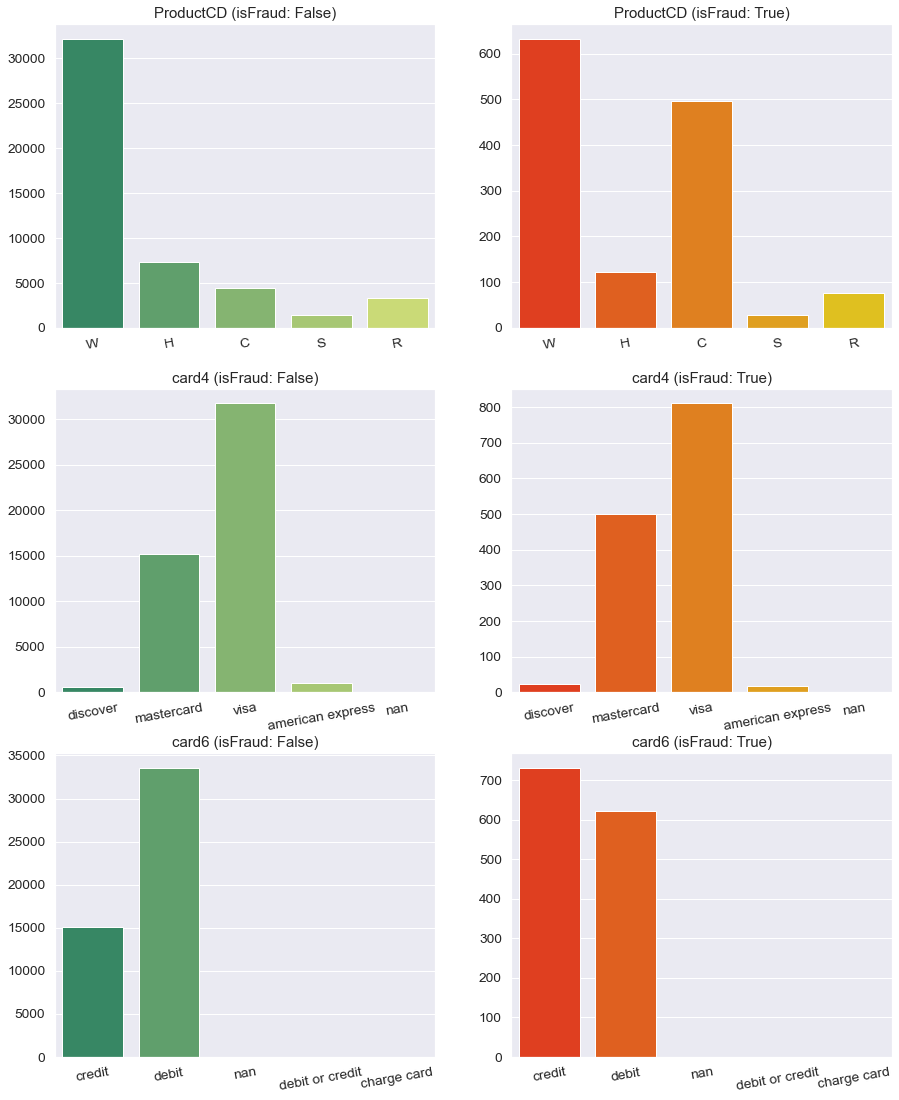

In [15]:
palettes = ['summer', 'autumn']
plt.figure(figsize=(15, 19))

for i, feature in enumerate(['ProductCD', 'card4', 'card6']):
    order = train_df[feature].unique()
    for j in (0, 1):
        plt.subplot(3, 2, j+i*2+1)
        sns.countplot(
            x=feature,
            data=train_df[train_df[target_column] == j],
            order=order,
            palette=palettes[j])
        plt.title(f'{feature} (isFraud: {bool(j)})')
        plt.xlabel('')
        plt.ylabel('')
        plt.xticks(rotation=10)

## Основное задание

Даны выборки для обучения и для тестирования. Задание заключается в том, чтобы попробовать разные способы валидации, проанализировать плюсы / минусы каждой и сделать выводы о том, какой способ валидации наиболее устойчивый в данной задаче. Метрика качества для оценки прогнозов - ROC-AUC, название целевой переменной - IsFraud. Рекомендуется использовать модели градиетного бустинга, реализация любая.

### Задание 1

Сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (TransactionID), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на тестовой выборке, оценить расхождение по сравнению с качеством на обучающей выборке и тестовой выборке.

Подтвердим три предположения по признаку `TransactionID`:
 - каждый объект в данных для обучения - уникальная транзакция;
 - -//- в данных для теста;
 - транзакций из данных для обучения нет в данных для теста.

In [16]:
assert train_df['TransactionID'].nunique() == train_df.shape[0]
assert test_df['TransactionID'].nunique() == test_df.shape[0]
assert set(test_df['TransactionID']).isdisjoint(set(train_df['TransactionID']))

Таким образом, признак `TransactionID` по сути содержит идентификаторы объектов. Как показано выше при исследовании признака `TransactionDT` они упорядочены во времени в каждом из датафреймов.

Исключим их из данных для обучения и оставим только количественные признаки. Заполним пропуски нехарактерным значением -9999.

In [17]:
numeric_features = train_df.select_dtypes(exclude='object').columns

X = train_df[numeric_features].drop(columns=['TransactionID', 'isFraud', 'TransactionDT']).fillna(-9999)
y = train_df[target_column]

Проделаем то же самое с данными для теста:

In [18]:
X_test = test_df[numeric_features].drop(columns=['TransactionID', 'isFraud', 'TransactionDT']).fillna(-9999)
y_test = test_df[target_column]

Количества деревьев для модели бустинга - от 10 до 310 с шагом 20:

In [19]:
estimator_counts = np.arange(10, 330, 20)

**Подбор количества деревьев**:

 - выделим четвёртую часть данных на оценочную выборку (*X_eval*, *y_eval*);
 - задан критерий до достижения сходимости (*early_stopping_rounds* в catboost).

In [20]:
train_scores, eval_scores = [], []

for j in tqdm(estimator_counts):
    X_train, X_eval, y_train, y_eval = train_test_split(
        X, y,
        test_size=0.25,
        shuffle=True,
        random_state=j,
    )
    
    eval_pool = Pool(X_eval, y_eval)
    
    catb = CatBoostClassifier(eval_metric='AUC', n_estimators=j, silent=True, random_state=j)
    catb.fit(X_train, y_train, eval_set=eval_pool, early_stopping_rounds=10)  
    
    train_score = roc_auc_score(y_train, catb.predict_proba(X_train)[:, 1])
    eval_score = roc_auc_score(y_eval, catb.predict_proba(X_eval)[:, 1])
    
    train_scores.append(train_score)
    eval_scores.append(eval_score)

100%|██████████████████████████████████████████| 16/16 [03:40<00:00, 13.80s/it]


Графики метрик качества на обучающей и оценочной выборках в зависимости от количества деревьев:

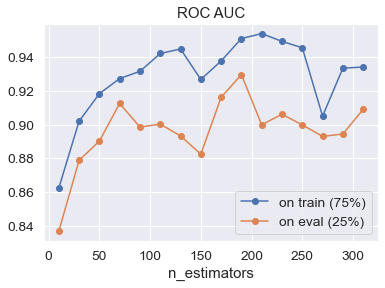

In [21]:
plt.plot(estimator_counts, train_scores, label='on train (75%)', marker='o')
plt.plot(estimator_counts, eval_scores, label='on eval (25%)', marker='o')
plt.title('ROC AUC')
plt.xlabel('n_estimators')
plt.legend(loc='best')
plt.grid(True)
plt.show()

Удалось подобрать такое количество деревьев, при котором разница метрик на выборках не выходит за пятипроцентный коридор. Проверим полученную модель на данных для теста:

In [22]:
test_score = roc_auc_score(y_test, catb.predict_proba(X_test)[:, 1])

print(f'Train-score: {train_score:.4f}\nEval-score:  {eval_score:.4f}\n')
print(f'Test-score:  {test_score:.4f}')

Train-score: 0.9341
Eval-score:  0.9090

Test-score:  0.8571


Метрика на данных для теста отличается от метрики на обучающей выборке более, чем на 5%.

### Задание 2

Сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1.

Выделим другую четвёртую часть данных на валидационную выборку (*X_valid*, *y_valid*):

In [23]:
train_scores, eval_scores, valid_scores = [], [], []

for j in tqdm(estimator_counts):
    X_train, X_eval, y_train, y_eval = train_test_split(
        X, y,
        test_size=0.25,
        shuffle=True,
        random_state=j+1,
    )

    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train,
        test_size=1/3,
        shuffle=True,
        random_state=j+2,
    )
    
    eval_pool = Pool(X_eval, y_eval)
    
    catb = CatBoostClassifier(eval_metric='AUC', n_estimators=j, silent=True, random_state=j)
    catb.fit(X_train, y_train, eval_set=eval_pool, early_stopping_rounds=10)  
    
    train_score = roc_auc_score(y_train, catb.predict_proba(X_train)[:, 1])
    eval_score = roc_auc_score(y_eval, catb.predict_proba(X_eval)[:, 1])
    valid_score = roc_auc_score(y_valid, catb.predict_proba(X_valid)[:, 1])
    
    train_scores.append(train_score)
    eval_scores.append(eval_score)
    valid_scores.append(valid_score)

100%|██████████████████████████████████████████| 16/16 [02:44<00:00, 10.28s/it]


Графики метрик качества на обучающей, оценочной и валидационной выборках в зависимости от количества деревьев:

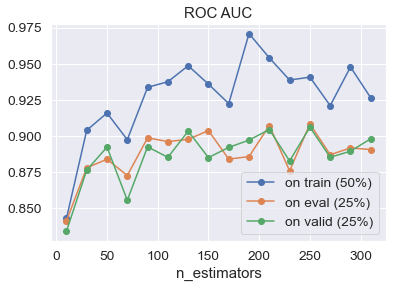

In [24]:
plt.plot(estimator_counts, train_scores, label='on train (50%)', marker='o')
plt.plot(estimator_counts, eval_scores, label='on eval (25%)', marker='o')
plt.plot(estimator_counts, valid_scores, label='on valid (25%)', marker='o')
plt.title('ROC AUC')
plt.xlabel('n_estimators')
plt.legend(loc='best')
plt.grid(True)
plt.show()

Метрика на данных для теста также отличается от метрики на обучающей выборке более, чем на 5%:

In [25]:
test_score = roc_auc_score(y_test, catb.predict_proba(X_test)[:, 1])

print(f'Train-score: {train_score:.4f}\nEval-score:  {eval_score:.4f}\nValid-score: {valid_score:.4f}\n')
print(f'Test-score:  {test_score:.4f}')

Train-score: 0.9263
Eval-score:  0.8906
Valid-score: 0.8981

Test-score:  0.8481


### Задание 3

Построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на тестовом выборке относительно полученного доверительного интервала. Сделать выводы.

In [26]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [27]:
np.random.seed(42)
scores = create_bootstrap_metrics(y_valid, catb.predict_proba(X_valid)[:, 1], roc_auc_score)
confidence_interval = [round(bound, 3) for bound in calculate_confidence_interval(scores)]

print(f'Test-score:  {test_score:.4f}')
print(f'Confidence interval: {confidence_interval}')

Test-score:  0.8481
Confidence interval: [0.878, 0.917]


Значение метрики на данных для теста не попало в рассчитанный доверительный интервал, поэтому этот тип валидации не особо успешен.

### Задание 4

Выполнить Adversarial Validation на основе данных из обучения / теста, подобрать объема из обучающей выборки, которые сильно похожи на объекты из тестовой выборки, и использовать их в качестве валидационного набора. Сделать выводы о полученных результатах.

In [28]:
X_adv = pd.concat(
    [X, X_test],
    axis=0
)

y_adv = np.hstack((
    np.zeros(X.shape[0]),
    np.ones(X_test.shape[0])
))

assert X_adv.shape[0] == y_adv.shape[0]

In [29]:
catb_adv = CatBoostClassifier(eval_metric='AUC', silent=True, random_state=42)
catb_adv.fit(X_adv, y_adv)

In [30]:
y_proba = catb_adv.predict_proba(X)[:, 1]

In [31]:
adv_res = pd.DataFrame(
    pd.cut(
        y_proba, bins=np.arange(0, 1.025, 0.025)
    ),
    index=X.index,
    columns=['intervals']
)

In [32]:
adv_res['intervals'].value_counts().sort_index()

(0.0, 0.025]     12021
(0.025, 0.05]     2175
(0.05, 0.075]      782
(0.075, 0.1]       642
(0.1, 0.125]       580
(0.125, 0.15]      707
(0.15, 0.175]      734
(0.175, 0.2]       778
(0.2, 0.225]       751
(0.225, 0.25]      750
(0.25, 0.275]      747
(0.275, 0.3]       765
(0.3, 0.325]       710
(0.325, 0.35]      686
(0.35, 0.375]      674
(0.375, 0.4]       680
(0.4, 0.425]       728
(0.425, 0.45]      796
(0.45, 0.475]      863
(0.475, 0.5]      1022
(0.5, 0.525]      1224
(0.525, 0.55]     1648
(0.55, 0.575]     2265
(0.575, 0.6]      3093
(0.6, 0.625]      3506
(0.625, 0.65]     2719
(0.65, 0.675]     1501
(0.675, 0.7]       815
(0.7, 0.725]       547
(0.725, 0.75]      650
(0.75, 0.775]      824
(0.775, 0.8]      1095
(0.8, 0.825]      1138
(0.825, 0.85]      685
(0.85, 0.875]      179
(0.875, 0.9]        82
(0.9, 0.925]       158
(0.925, 0.95]      243
(0.95, 0.975]       34
(0.975, 1.0]         4
Name: intervals, dtype: int64

Отберем в оценочную выборку те объекты, предсказание для которых не менее 0.625:

In [33]:
adv_res['for_eval'] = [interval.left >= 0.625 for interval in adv_res['intervals']]
eval_mask = adv_res['for_eval'] == True
np.sum(eval_mask)

10674

Применим маску к данным для обучения:

In [34]:
X_train = X[~eval_mask]
y_train = y[~eval_mask]

X_eval = X[eval_mask]
y_eval = y[eval_mask]
eval_pool = Pool(X_eval, y_eval)

Обучим классификатор с минимально-достаточным (согласно предыдущим исследованиям) количеством деревьев:

In [35]:
catb = CatBoostClassifier(eval_metric='AUC', n_estimators=130, silent=True, random_state=42)
catb.fit(X_train, y_train, eval_set=eval_pool, early_stopping_rounds=10)  

Значения метрики на обучающей, оценочной выборках и данных для теста:

In [36]:
train_score = roc_auc_score(y_train, catb.predict_proba(X_train)[:, 1])
eval_score = roc_auc_score(y_eval, catb.predict_proba(X_eval)[:, 1])
test_score = roc_auc_score(y_test, catb.predict_proba(X_test)[:, 1])

print(f'Train-score: {train_score:.4f}\nEval-score:  {eval_score:.4f}', end=' ')

np.random.seed(42)
scores = create_bootstrap_metrics(y_eval, catb.predict_proba(X_eval)[:, 1], roc_auc_score)
confidence_interval = [round(bound, 3) for bound in calculate_confidence_interval(scores)]
print(f'(confidence interval: {confidence_interval})\n')

print(f'Test-score:  {test_score:.4f}')

Train-score: 0.8817
Eval-score:  0.8016 (confidence interval: [0.772, 0.831])

Test-score:  0.8432


Значение метрики серьёзно просело - в том числе и на оценочной выборке. Тем не менее, это позволило приблизить значение метрики на данных для теста на расстояние меньше, чем 5%.

### Задание 5

Сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных;

In [37]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          proba: bool,
                          cv_strategy: object,
                          use_groups: bool = False,
                          groups: pd.Series = None):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    proba: bool
        Флаг - расчитывать ли вероятностные
        предсказания для метрики.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])
    
    splits = cv_strategy.split(X, y, groups) if use_groups else cv_strategy.split(X, y)
    for fold_number, (train_idx, valid_idx) in enumerate(splits):
        x_train, x_valid = X[X.index.isin(train_idx)], X[X.index.isin(valid_idx)]
        y_train, y_valid = y[y.index.isin(train_idx)], y[y.index.isin(valid_idx)]

        estimator.fit(x_train, y_train)
        
        if proba:
            y_train_pred = estimator.predict_proba(x_train)[:, 1]
            y_valid_pred = estimator.predict_proba(x_valid)[:, 1]
        else:
            y_train_pred = estimator.predict(x_train)
            y_valid_pred = estimator.predict(x_valid)
        
        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred
        
        np.random.seed(42)
        scores = create_bootstrap_metrics(y_valid, y_valid_pred, metric)
        confidence_interval = [round(bound, 3) for bound in calculate_confidence_interval(scores)]

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print(f'(confidence interval: {confidence_interval})')
        print("="*69)
        
        estimator = estimator.copy()
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [38]:
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42) # StratifiedKFold
catb = CatBoostClassifier(eval_metric='AUC', n_estimators=130, silent=True, random_state=42)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    X, y, catb, metric=roc_auc_score, proba=True, cv_strategy=cv_strategy
)

Fold: 1, train-observations = 40000, valid-observations = 10001
train-score = 0.9527, valid-score = 0.8739
(confidence interval: [0.844, 0.899])
Fold: 2, train-observations = 40001, valid-observations = 10000
train-score = 0.9397, valid-score = 0.9151
(confidence interval: [0.888, 0.936])
Fold: 3, train-observations = 40001, valid-observations = 10000
train-score = 0.9454, valid-score = 0.9275
(confidence interval: [0.907, 0.945])
Fold: 4, train-observations = 40001, valid-observations = 10000
train-score = 0.943, valid-score = 0.9032
(confidence interval: [0.882, 0.924])
Fold: 5, train-observations = 40001, valid-observations = 10000
train-score = 0.9411, valid-score = 0.9081
(confidence interval: [0.886, 0.929])
CV-results train: 0.9444 +/- 0.005
CV-results valid: 0.9056 +/- 0.018
OOF-score = 0.9044


Кросс-валидация по признаку `TransactionID` повысила значения метрик, однако их разброс очень мал.
<br>Рассчитаем метрику на самом лучшем (третьем согласно кросс-валидации) классификаторе:

In [39]:
test_score = roc_auc_score(y_test, estimators[2].predict_proba(X_test)[:, 1])

print(f'Test-score:  {test_score:.4f}')

Test-score:  0.8614


Тем не менее, она отличается от метрики на обучающей выборке более, чем на 5%, и в доверительный интервал не попадает.

### Задание 6 * (опциональное)

Сделать Hold-Out валидацию по времени (TransactionDT), повторить процедуры из п.1 / п.2 (на ваш выбор). Построить доверительный интервал, сравнить качество на тестовой выборке с полученным доверительным интервалом. Сделать выводы.

Данные в датафрейме уже упорядочены по времени. Применим кросс-валидацию по времени, чтобы найти достаточный размер обучающей выборки, после чего воспользуемся обученным на ней классификатором на данных для теста:

In [40]:
tscv_strategy = TimeSeriesSplit(max_train_size=None, n_splits=5)
catb = CatBoostClassifier(eval_metric='AUC', n_estimators=130, silent=True, random_state=42)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    X, y, catb, metric=roc_auc_score, proba=True, cv_strategy=tscv_strategy
)

Fold: 1, train-observations = 8336, valid-observations = 8333
train-score = 0.9881, valid-score = 0.8531
(confidence interval: [0.824, 0.88])
Fold: 2, train-observations = 16669, valid-observations = 8333
train-score = 0.9626, valid-score = 0.8637
(confidence interval: [0.836, 0.888])
Fold: 3, train-observations = 25002, valid-observations = 8333
train-score = 0.9599, valid-score = 0.8635
(confidence interval: [0.836, 0.89])
Fold: 4, train-observations = 33335, valid-observations = 8333
train-score = 0.9496, valid-score = 0.8966
(confidence interval: [0.872, 0.92])
Fold: 5, train-observations = 41668, valid-observations = 8333
train-score = 0.9503, valid-score = 0.8953
(confidence interval: [0.868, 0.922])
CV-results train: 0.9621 +/- 0.014
CV-results valid: 0.8745 +/- 0.018
OOF-score = 0.7689


Самый лучший результат дала выборка из первых 33335 объектов (четвертый классификатор) - наибольшая метрика на валидационной выборке при наименьшей разнице со значением метрики на обучающей выборке.

In [41]:
test_score = roc_auc_score(y_test, estimators[3].predict_proba(X_test)[:, 1])

print(f'Test-score:  {test_score:.4f}')

Test-score:  0.8557


Значение метрики на данных для теста также отличается от метрики на обучающей выборке более, чем на 5%, и в доверительный интервал не попадает.

### Задание 7 ** (совсем опциональное)

В данном наборе данных у нас есть ID-транзакции (TransactionID) и время транзакции (TransactionDT), но отсутствует ID-клиента, который совершал транзакции. Кажется, что в этой задаче валидация по клиенту работала бы хорошо. Предложить критерий, по которому можно выделить клиентов и сделать п.5, используя созданное определение клиента, используя валидацию по клиенту (GroupKFold).

*Применим всё из разбора задания:*

In [42]:
import hashlib

def card_info_hash(x):
    s = (str(x['card1'])+
         str(x['card2'])+
         str(x['card3'])+
         str(x['card4'])+
         str(x['card5'])+
         str(x['card6'])+
         x["ProductCD"])

    h = hashlib.sha256(s.encode('utf-8')).hexdigest()[0:15]
    return h

In [43]:
user_features = [f'card{i}' for i in range(1, 7)] + ['ProductCD']

train_uids = train_df[user_features].apply(lambda x: card_info_hash(x), axis=1)

In [44]:
gcv_strategy = GroupKFold(n_splits=5)
catb = CatBoostClassifier(eval_metric='AUC', n_estimators=130, silent=True, random_state=42)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    X, y, catb, metric=roc_auc_score, proba=True, cv_strategy=gcv_strategy, use_groups=True, groups=train_uids
)

Fold: 1, train-observations = 40000, valid-observations = 10001
train-score = 0.9563, valid-score = 0.8187
(confidence interval: [0.785, 0.85])
Fold: 2, train-observations = 40001, valid-observations = 10000
train-score = 0.9492, valid-score = 0.8384
(confidence interval: [0.814, 0.865])
Fold: 3, train-observations = 40001, valid-observations = 10000
train-score = 0.9483, valid-score = 0.7511
(confidence interval: [0.714, 0.787])
Fold: 4, train-observations = 40001, valid-observations = 10000
train-score = 0.9451, valid-score = 0.8472
(confidence interval: [0.823, 0.873])
Fold: 5, train-observations = 40001, valid-observations = 10000
train-score = 0.9484, valid-score = 0.8784
(confidence interval: [0.85, 0.903])
CV-results train: 0.9495 +/- 0.004
CV-results valid: 0.8267 +/- 0.042
OOF-score = 0.8262


Метрика на тестовых данных попадает в доверительный интервал, поэтому этот способ валидации самый лучший из рассмотренных:

In [45]:
test_score = roc_auc_score(y_test, estimators[4].predict_proba(X_test)[:, 1])

print(f'Test-score:  {test_score:.4f}')

Test-score:  0.8507
